In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from collections import defaultdict
from IPython.display import Audio, display
from scipy.io import wavfile
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from notebooks.tf.scheduler import SGDRScheduler

In [2]:
sample_rate, source_audio = wavfile.read("./data/donuts_hq.wav")
sample_start = sample_rate * 60
sample_end = sample_rate * 70
print("Sample rate:", sample_rate)

Sample rate: 32000


In [3]:
Audio(source_audio[sample_start:sample_end], rate=sample_rate)

In [4]:
def compress_with_pca(data, components, block_size=1024):
    samples = len(data)
    leftover = block_size - samples % block_size
    padded = np.lib.pad(data, (0, leftover), "constant", constant_values=0)
    
    reshaped = padded.reshape((len(padded) // block_size, block_size))
    
    pca = PCA(n_components=components)
    pca.fit(reshaped)
    
    transformed = pca.transform(reshaped)
    reconstructed = pca.inverse_transform(transformed).reshape((len(padded)))
    return pca, transformed, reconstructed

In [5]:
COMPONENT_COUNT = 50
SAMPLE_SIZE = 320

pca, transformed, constructed = compress_with_pca(
    source_audio, COMPONENT_COUNT, SAMPLE_SIZE
)
print(f"PCA Transformed audio shape: {transformed.shape}")
Audio(constructed[sample_start:sample_end], rate=sample_rate)

PCA Transformed audio shape: (17403, 50)


In [6]:
# BATCH_COUNT = len(source_audio) // SAMPLE_SIZE

# data_scale = np.amax(np.abs(source_audio))
# normalized_data = source_audio / data_scale

# batched = (normalized_data[:BATCH_COUNT * SAMPLE_SIZE]).reshape((
#     BATCH_COUNT, SAMPLE_SIZE
# ))
# batched.shape

In [7]:
k = 2048
centroid, label = kmeans2(transformed, k, minit='points')

In [8]:
counts = np.bincount(label)
np.amax(counts)

102

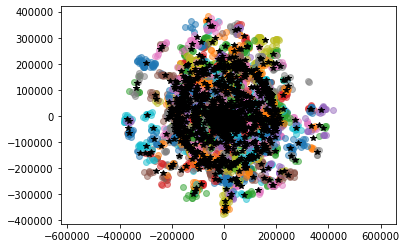

In [9]:
for i in range(k):
    w = transformed[label == i]
    plt.plot(w[:, 0], w[:, 1], "o", alpha=0.5, label=f"cluster {i}")

plt.plot(centroid[:, 0], centroid[:, 1], 'k*', label='centroids')
plt.axis('equal')
plt.show()

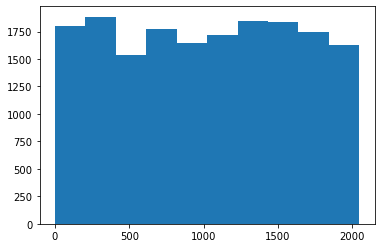

In [10]:
plt.hist(label)
plt.show()

In [11]:
BATCH_COUNT = min(len(label), len(source_audio) // SAMPLE_SIZE)

data_scale = np.amax(np.abs(source_audio))
normalized_data = source_audio / data_scale

batched = (normalized_data[:BATCH_COUNT * SAMPLE_SIZE]).reshape((
    BATCH_COUNT, SAMPLE_SIZE
))
label = label[:BATCH_COUNT]
print(label.shape)
print(batched.shape)

(17402,)
(17402, 320)


In [12]:
label[500:530]

array([1672, 1672, 1682,  928,  948, 1028,  807, 1028, 1184,  807,    6,
       1184, 1131,  139,  681,  681, 1245, 1202, 1202, 1202, 1611, 1611,
       1611,  415,  415,  871,  312, 1919,  871,  158])

In [13]:
grouped_by_label = defaultdict(list)
for index, data in enumerate(batched):
    grouped_by_label[label[index]].append(data)

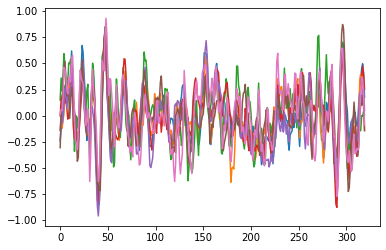

None

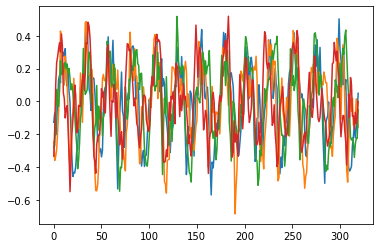

None

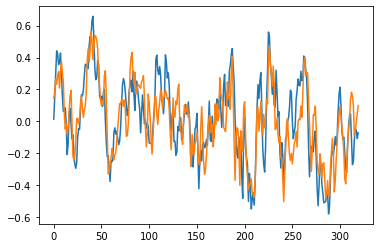

None

In [14]:
for entry in grouped_by_label[0]:
    plt.plot(entry)
display(plt.show())
for entry in grouped_by_label[2]:
    plt.plot(entry)
display(plt.show())
for entry in grouped_by_label[1000]:
    plt.plot(entry)
display(plt.show())

In [15]:
TRAINING_BATCH_SIZE = 64

In [47]:
def process_input_data(input_data):
    input_data = tf.data.Dataset.from_tensor_slices(input_data)
    input_data = input_data.window(3, shift=1, drop_remainder=True)
    input_data = input_data.flat_map(lambda window: window)
    input_data = input_data.map(lambda x: tf.one_hot(x, depth=k))
    input_data = input_data.batch(3, drop_remainder=True)
    return input_data

def process_datasets(input_data, target_data):
    input_data = process_input_data(input_data)
    target_data = tf.data.Dataset.from_tensor_slices(target_data)
    target_data = target_data.skip(1)
    return (input_data, target_data)

def test_process_datasets():
    a1, a2 = process_datasets(np.array(range(100)), np.array(range(100)))
    a3 = tf.data.Dataset.zip((a1, a2))

    for index, (group_input, group_target) in enumerate(a3.take(100)):
        assert np.argmax(group_input[0]) == index + 0
        assert np.argmax(group_input[1]) == index + 1
        assert np.argmax(group_input[2]) == index + 2
        assert group_target == index + 1


test_process_datasets()

label_set, sample_set = process_datasets(label, batched)
zipped_set = tf.data.Dataset.zip((
    label_set, sample_set,
))

for group_input, group_target in zipped_set.take(5):
    print(np.argmax(group_input, axis=1))

training_set = zipped_set.batch(TRAINING_BATCH_SIZE, drop_remainder=True)
training_set

[123 123 123]
[123 123 291]
[123 291 121]
[ 291  121 1539]
[ 121 1539   31]


<BatchDataset shapes: ((64, 3, 2048), (64, 320)), types: (tf.float32, tf.float64)>

In [25]:
for labels, samples in training_set.take(1):
    ex_sample = samples[63]
    audiotest = np.array([])
    for entry in samples:
        audiotest = np.concatenate((audiotest, entry))
    print(audiotest.shape)
    print(np.argmax(labels[63], axis=1))
    display(Audio(audiotest * data_scale, rate=sample_rate))

(20480,)
[ 351  364 1611]


In [26]:
def build_model(lc, h1, h2, oc):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(
            batch_size=TRAINING_BATCH_SIZE,
            input_shape=(3, lc,),
            dtype=tf.float32,
        ),
        tf.keras.layers.Dense(
            units=h1,
            dtype=tf.float32,
        ),
        tf.keras.layers.PReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=h2,
            dtype=tf.float32,
        ),
        tf.keras.layers.PReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(
            units=oc,
            dtype=tf.float32,
        ),
    ])
    return model, f"./training-checkpoints/k-means-audio-3-{lc}-{h1}-{h2}-{oc}"

model, checkpoint_dir = build_model(
    lc=k,
    h1=k,
    h2=k * 2,
    oc=SAMPLE_SIZE,
)
model.build()

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)

model.summary()
model.compile("adam", loss=tf.keras.losses.MSE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (64, 3, 2048)             4196352   
_________________________________________________________________
p_re_lu (PReLU)              (64, 3, 2048)             6144      
_________________________________________________________________
batch_normalization (BatchNo (64, 3, 2048)             8192      
_________________________________________________________________
flatten (Flatten)            (64, 6144)                0         
_________________________________________________________________
dense_1 (Dense)              (64, 4096)                25169920  
_________________________________________________________________
p_re_lu_1 (PReLU)            (64, 4096)                4096      
_________________________________________________________________
batch_normalization_1 (Batch (64, 4096)                1

In [27]:
checkpoint_prefix = os.path.abspath(
    os.path.join(checkpoint_dir, "ckpt_{epoch}")
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor="loss",
    save_best_only=True,
    period=10,
)

learningrate_callback = SGDRScheduler(
    min_lr=1e-6,
    max_lr=1e-3,
    steps_per_epoch=54,
    lr_decay=0.9,
    cycle_length=5,
    mult_factor=1.5
)

In [28]:
EPOCHS = 100
history = model.fit(
    training_set,
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        learningrate_callback,
    ],
)

Epoch 1/100
271/271 [==============================] - 6s 22ms/step - loss: 0.0500
Epoch 2/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0249
Epoch 3/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0207
Epoch 4/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0142
Epoch 5/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0158
Epoch 6/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0123
Epoch 7/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0098
Epoch 8/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0094
Epoch 9/100
271/271 [==============================] - 5s 19ms/step - loss: 0.0103: 0s - lo
Epoch 10/100
271/271 [==============================] - 12s 45ms/step - loss: 0.0089
Epoch 11/100
271/271 [==============================] - 5s 20ms/step - loss: 0.0078
Epoch 12/100
271/271 [==============================] - 5s 18ms/step - loss

271/271 [==============================] - 5s 17ms/step - loss: 0.0029
Epoch 99/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0029
Epoch 100/100
271/271 [==============================] - 5s 17ms/step - loss: 0.0030


In [30]:
labels_test = label_set.batch(TRAINING_BATCH_SIZE, drop_remainder=True)
output = np.array([], np.float32)

for batch in labels_test:
    res = model(batch).numpy().flatten()
    output = np.concatenate((output, res))

output = output * data_scale

In [31]:
Audio(output[sample_start:sample_end] * data_scale, rate=sample_rate)

In [62]:
rnn_checkpoint_dir = "./training-checkpoints/k-means-audio-dictionary-rnn"
last_rnn_checkpoint = tf.train.latest_checkpoint(rnn_checkpoint_dir)

RNN_BATCH_SIZE = 16
RNN_UNITS = 1024
EMBEDDING_UNITS = 64
VOCABULARY_SIZE = k

def build_rnn(vocabulary_size, embedding_dimension, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            vocabulary_size,
            embedding_dimension,
            batch_input_shape=[batch_size, None],
            name="embedding",
        ),
        tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer="glorot_uniform",
        ),
        tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer="glorot_uniform",
        ),
        tf.keras.layers.Dense(
            vocabulary_size,
            name="out",
        ),
    ], "RNN")
    return model

rnn = build_rnn(
    vocabulary_size=VOCABULARY_SIZE,
    embedding_dimension=EMBEDDING_UNITS,
    rnn_units=RNN_UNITS,
    batch_size=RNN_BATCH_SIZE,
)
if last_rnn_checkpoint:
    print("Loaded!")
    rnn.load_weights(last_rnn_checkpoint)

# rnn.build()
rnn.summary()

def rnn_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        labels,
        logits,
        from_logits=True,
    )

rnn.compile("adam", loss=rnn_loss)

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (16, None, 64)            131072    
_________________________________________________________________
gru_6 (GRU)                  (16, None, 1024)          3348480   
_________________________________________________________________
gru_7 (GRU)                  (16, None, 1024)          6297600   
_________________________________________________________________
out (Dense)                  (16, None, 2048)          2099200   
Total params: 11,876,352
Trainable params: 11,876,352
Non-trainable params: 0
_________________________________________________________________


In [55]:
RNN_SEQUENCE_LENGTH = 200

print("Training data sequences:", len(label) // RNN_SEQUENCE_LENGTH)
rnn_dataset = tf.data.Dataset.from_tensor_slices(label)
rnn_sequences = rnn_dataset.batch(
    RNN_SEQUENCE_LENGTH + 1,
    drop_remainder=True
)

def split_input_target(sequence):
    input_data = sequence[:-1]
    target_data = sequence[1:]
    return input_data, target_data

rnn_sequences = rnn_sequences.map(split_input_target)
rnn_sequences

Training data sequences: 87


<MapDataset shapes: ((200,), (200,)), types: (tf.int32, tf.int32)>

In [56]:
rnn_training_data = (
    rnn_sequences
    .shuffle(1024)
    .batch(RNN_BATCH_SIZE, drop_remainder=True)
)

rnn_training_data

<BatchDataset shapes: ((16, 200), (16, 200)), types: (tf.int32, tf.int32)>

In [48]:
def convert_integers_to_audio(integers):
    integers = process_input_data(integers)
    batched = integers.batch(TRAINING_BATCH_SIZE, drop_remainder=True)
    
    result = []
    for batch in batched:
        decoded = model(batch).numpy().flatten()
        result.extend(decoded)
    return np.array(result) * data_scale

In [49]:
# print(label.shape)
testaudio = convert_integers_to_audio(label)

In [51]:
display(Audio(testaudio[sample_start:sample_end], rate=sample_rate))

In [60]:
rnn_checkpoint_prefix = os.path.abspath(
    os.path.join(rnn_checkpoint_dir, "ckpt_{epoch}")
)

rnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=rnn_checkpoint_prefix,
    save_weights_only=True,
    monitor="loss",
    save_best_only=True,
    period=100,
)
rnn_lr_schedule = SGDRScheduler(
    min_lr=1e-6,
    max_lr=1e-3,
    steps_per_epoch=54,
    lr_decay=0.9,
    cycle_length=5,
    mult_factor=1.5
)

In [63]:
EPOCHS = 1000
history = rnn.fit(
    rnn_training_data,
    epochs=EPOCHS,
    callbacks=[
        rnn_checkpoint_callback,
#         rnn_lr_schedule,
    ],
)

Train for 5 steps
Epoch 1/1000
5/5 [==============================] - 3s 666ms/step - loss: 7.6198
Epoch 2/1000
5/5 [==============================] - 1s 288ms/step - loss: 7.4974
Epoch 3/1000
5/5 [==============================] - 1s 290ms/step - loss: 7.3857
Epoch 4/1000
5/5 [==============================] - 1s 289ms/step - loss: 7.3227
Epoch 5/1000
5/5 [==============================] - 1s 287ms/step - loss: 7.2751
Epoch 6/1000
5/5 [==============================] - 1s 291ms/step - loss: 7.1667
Epoch 7/1000
5/5 [==============================] - 1s 288ms/step - loss: 7.0873
Epoch 8/1000
5/5 [==============================] - 1s 288ms/step - loss: 7.0280
Epoch 9/1000
5/5 [==============================] - 1s 297ms/step - loss: 6.8354
Epoch 10/1000
5/5 [==============================] - 1s 288ms/step - loss: 6.7236
Epoch 11/1000
5/5 [==============================] - 2s 303ms/step - loss: 6.4462
Epoch 12/1000
5/5 [==============================] - 1s 286ms/step - loss: 6.2893
Epoch 1

5/5 [==============================] - 1s 272ms/step - loss: 0.1556
Epoch 101/1000
5/5 [==============================] - 1s 271ms/step - loss: 0.1487
Epoch 102/1000
5/5 [==============================] - 1s 271ms/step - loss: 0.1505
Epoch 103/1000
5/5 [==============================] - 1s 267ms/step - loss: 0.1482
Epoch 104/1000
5/5 [==============================] - 1s 268ms/step - loss: 0.1465
Epoch 105/1000
5/5 [==============================] - 1s 271ms/step - loss: 0.1337
Epoch 106/1000
5/5 [==============================] - 1s 270ms/step - loss: 0.1243
Epoch 107/1000
5/5 [==============================] - 1s 269ms/step - loss: 0.1275
Epoch 108/1000
5/5 [==============================] - 1s 273ms/step - loss: 0.1139
Epoch 109/1000
5/5 [==============================] - 1s 271ms/step - loss: 0.1216
Epoch 110/1000
5/5 [==============================] - 1s 270ms/step - loss: 0.1212
Epoch 111/1000
5/5 [==============================] - 1s 269ms/step - loss: 0.1162
Epoch 112/1000
5/5 

5/5 [==============================] - 1s 269ms/step - loss: 0.0301
Epoch 199/1000
5/5 [==============================] - 1s 269ms/step - loss: 0.0302
Epoch 200/1000
5/5 [==============================] - 1s 263ms/step - loss: 0.0281
Epoch 201/1000
5/5 [==============================] - 1s 269ms/step - loss: 0.0290
Epoch 202/1000
5/5 [==============================] - 1s 268ms/step - loss: 0.0279
Epoch 203/1000
5/5 [==============================] - 1s 267ms/step - loss: 0.0293
Epoch 204/1000
5/5 [==============================] - 1s 273ms/step - loss: 0.0271
Epoch 205/1000
5/5 [==============================] - 1s 270ms/step - loss: 0.0294
Epoch 206/1000
5/5 [==============================] - 1s 271ms/step - loss: 0.0294
Epoch 207/1000
5/5 [==============================] - 1s 273ms/step - loss: 0.0301
Epoch 208/1000
5/5 [==============================] - 1s 270ms/step - loss: 0.0276
Epoch 209/1000
5/5 [==============================] - 1s 271ms/step - loss: 0.0281
Epoch 210/1000
5/5 

5/5 [==============================] - 1s 260ms/step - loss: 0.0121
Epoch 297/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0110
Epoch 298/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0119
Epoch 299/1000
5/5 [==============================] - 1s 262ms/step - loss: 0.0106
Epoch 300/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0109
Epoch 301/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0105
Epoch 302/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0102
Epoch 303/1000
5/5 [==============================] - 1s 263ms/step - loss: 0.0114
Epoch 304/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0109
Epoch 305/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0104
Epoch 306/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0100
Epoch 307/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0092
Epoch 308/1000
5/5 

Epoch 395/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0065
Epoch 396/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0059
Epoch 397/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0062
Epoch 398/1000
5/5 [==============================] - 1s 263ms/step - loss: 0.0057
Epoch 399/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0060
Epoch 400/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0055
Epoch 401/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0064
Epoch 402/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0067
Epoch 403/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0065
Epoch 404/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0063
Epoch 405/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0063
Epoch 406/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0063
Epoc

5/5 [==============================] - 1s 260ms/step - loss: 0.0028
Epoch 494/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0034
Epoch 495/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0030
Epoch 496/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0031
Epoch 497/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0029
Epoch 498/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.0028
Epoch 499/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0033
Epoch 500/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0031
Epoch 501/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0031
Epoch 502/1000
5/5 [==============================] - 1s 263ms/step - loss: 0.0031
Epoch 503/1000
5/5 [==============================] - 1s 259ms/step - loss: 0.0036
Epoch 504/1000
5/5 [==============================] - 1s 260ms/step - loss: 0.0032
Epoch 505/1000
5/5 

5/5 [==============================] - 1s 298ms/step - loss: 0.0020
Epoch 592/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0026
Epoch 593/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0024
Epoch 594/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0029
Epoch 595/1000
5/5 [==============================] - 1s 290ms/step - loss: 0.0025
Epoch 596/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0027
Epoch 597/1000
5/5 [==============================] - 1s 297ms/step - loss: 0.0046
Epoch 598/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0049
Epoch 599/1000
5/5 [==============================] - 1s 291ms/step - loss: 0.0053
Epoch 600/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0047
Epoch 601/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0037
Epoch 602/1000
5/5 [==============================] - 1s 291ms/step - loss: 0.0037
Epoch 603/1000
5/5 

5/5 [==============================] - 1s 293ms/step - loss: 0.0095
Epoch 690/1000
5/5 [==============================] - 1s 298ms/step - loss: 0.0119
Epoch 691/1000
5/5 [==============================] - 1s 291ms/step - loss: 0.0129
Epoch 692/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0157
Epoch 693/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0198
Epoch 694/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0177
Epoch 695/1000
5/5 [==============================] - 2s 311ms/step - loss: 0.0213
Epoch 696/1000
5/5 [==============================] - 1s 289ms/step - loss: 0.0262
Epoch 697/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0204
Epoch 698/1000
5/5 [==============================] - 1s 295ms/step - loss: 0.0175
Epoch 699/1000
5/5 [==============================] - 1s 289ms/step - loss: 0.0175
Epoch 700/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0172
Epoch 701/1000
5/5 

5/5 [==============================] - 1s 288ms/step - loss: 0.0028
Epoch 788/1000
5/5 [==============================] - 1s 287ms/step - loss: 0.0026
Epoch 789/1000
5/5 [==============================] - 1s 295ms/step - loss: 0.0029
Epoch 790/1000
5/5 [==============================] - 1s 299ms/step - loss: 0.0027
Epoch 791/1000
5/5 [==============================] - 1s 291ms/step - loss: 0.0025
Epoch 792/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0022
Epoch 793/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0026
Epoch 794/1000
5/5 [==============================] - 1s 289ms/step - loss: 0.0020
Epoch 795/1000
5/5 [==============================] - 1s 291ms/step - loss: 0.0030
Epoch 796/1000
5/5 [==============================] - 1s 290ms/step - loss: 0.0028
Epoch 797/1000
5/5 [==============================] - 2s 300ms/step - loss: 0.0028
Epoch 798/1000
5/5 [==============================] - 1s 290ms/step - loss: 0.0025
Epoch 799/1000
5/5 

5/5 [==============================] - 1s 295ms/step - loss: 0.0018
Epoch 886/1000
5/5 [==============================] - 1s 296ms/step - loss: 0.0014
Epoch 887/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0014
Epoch 888/1000
5/5 [==============================] - 1s 296ms/step - loss: 0.0017
Epoch 889/1000
5/5 [==============================] - 1s 298ms/step - loss: 0.0013
Epoch 890/1000
5/5 [==============================] - 1s 299ms/step - loss: 0.0013
Epoch 891/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0019
Epoch 892/1000
5/5 [==============================] - 1s 290ms/step - loss: 0.0014
Epoch 893/1000
5/5 [==============================] - 1s 295ms/step - loss: 0.0014
Epoch 894/1000
5/5 [==============================] - 2s 302ms/step - loss: 0.0013
Epoch 895/1000
5/5 [==============================] - 1s 298ms/step - loss: 0.0018
Epoch 896/1000
5/5 [==============================] - 1s 298ms/step - loss: 0.0017
Epoch 897/1000
5/5 

5/5 [==============================] - 1s 294ms/step - loss: 0.0018
Epoch 984/1000
5/5 [==============================] - 1s 299ms/step - loss: 0.0021
Epoch 985/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0019
Epoch 986/1000
5/5 [==============================] - 1s 292ms/step - loss: 0.0013
Epoch 987/1000
5/5 [==============================] - 1s 289ms/step - loss: 0.0020
Epoch 988/1000
5/5 [==============================] - 1s 299ms/step - loss: 0.0016
Epoch 989/1000
5/5 [==============================] - 1s 294ms/step - loss: 0.0017
Epoch 990/1000
5/5 [==============================] - 1s 298ms/step - loss: 0.0014
Epoch 991/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0017
Epoch 992/1000
5/5 [==============================] - 1s 295ms/step - loss: 0.0012
Epoch 993/1000
5/5 [==============================] - 1s 297ms/step - loss: 0.0013
Epoch 994/1000
5/5 [==============================] - 1s 293ms/step - loss: 0.0012
Epoch 995/1000
5/5 

In [64]:
rnn_generator = build_rnn(
    vocabulary_size=VOCABULARY_SIZE,
    embedding_dimension=EMBEDDING_UNITS,
    rnn_units=RNN_UNITS,
    batch_size=1,
)
rnn_generator.load_weights(tf.train.latest_checkpoint(rnn_checkpoint_dir))
rnn_generator.build()
rnn_generator.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 64)             131072    
_________________________________________________________________
gru_8 (GRU)                  (1, None, 1024)           3348480   
_________________________________________________________________
gru_9 (GRU)                  (1, None, 1024)           6297600   
_________________________________________________________________
out (Dense)                  (1, None, 2048)           2099200   
Total params: 11,876,352
Trainable params: 11,876,352
Non-trainable params: 0
_________________________________________________________________


In [65]:
def generate_audio_integers(model, input_eval, count=3200):
    generated_output = []
    
    temperature = 1.0
    
    input_eval = tf.expand_dims(input_eval, 0)
    
    model.reset_states()
    for i in range(count):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predictions /= temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)
        predicted_id = predicted_id[-1, 0].numpy()
        
        # Pass in the predicted character as input on the next round
        input_eval = tf.expand_dims([predicted_id], 0)
        generated_output.append(predicted_id)
    
    return generated_output

In [70]:
generated = generate_audio_integers(rnn_generator, range(10), count=64 * 100)
audio_data = convert_integers_to_audio(generated)
print(audio_data.shape)

(2027520,)


In [71]:
Audio(audio_data, rate=sample_rate)